In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import glob

In [2]:
# Load demand data
demand = pd.read_csv("demand.csv", parse_dates=["datetime"])

# Convert 'datetime' to 'timestamp' with correct format
demand.rename(columns={"datetime": "timestamp"}, inplace=True)
demand["timestamp"] = pd.to_datetime(demand["timestamp"], format="%d/%m/%Y %H:%M", errors="coerce")

In [3]:
# Load weather datasets
weather_files = glob.glob("*.csv")
weather_files.remove("demand.csv")
weather_dfs = {}

for file in weather_files:
    df = pd.read_csv(file, parse_dates=["datetime"])
    if "datetime" not in df.columns:
        raise ValueError(f"Missing 'datetime' column in {file}")
    df.rename(columns={"datetime": "timestamp"}, inplace=True)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    weather_dfs[file] = df


In [4]:
# Merge weather data
weather_dfs_list = list(weather_dfs.items())
file, merged_weather = weather_dfs_list[0]
location_name = file.split("/")[-1].replace(".csv", "")
merged_weather.rename(columns=lambda x: f"{location_name}_{x}" if x != "timestamp" else x, inplace=True)

for file, df in weather_dfs_list[1:]:
    location_name = file.split("/")[-1].replace(".csv", "")
    df.rename(columns=lambda x: f"{location_name}_{x}" if x != "timestamp" else x, inplace=True)
    merged_weather = merged_weather.merge(df, on="timestamp", how="outer")

final_df = demand.merge(merged_weather, on="timestamp", how="left")
final_df.dropna(axis=1, how="all", inplace=True)
final_df.fillna(method="ffill", inplace=True)
final_df.fillna(method="bfill", inplace=True)
final_df.head()


<ipython-input-4-b7e5373907fe>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method="ffill", inplace=True)
<ipython-input-4-b7e5373907fe>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method="bfill", inplace=True)


,timestamp,"actual_performance(10,000 kW)",hikone_precipitation,hikone_temperature,hikone_dew_point_temperature,hikone_humidity,hikone_wind_speed,hikone_wind_direction,hikone_snowfall,kyoto_precipitation,...,wakayama_wind_speed,wakayama_wind_direction,wakayama_snowfall,toyooka_precipitation,toyooka_temperature,toyooka_dew_point_temperature,toyooka_humidity,toyooka_wind_speed,toyooka_wind_direction,toyooka_snowfall
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,南,0.0,0.0,...,2.6,西南西,0.0,0.5,-0.3,-0.4,99.0,2.1,南南東,1.0
1,2021-01-01 01:00:00,1492,0.0,0.3,-4.7,69.0,3.7,南南西,0.0,0.0,...,1.5,北,0.0,1.5,-0.2,-0.3,99.0,2.0,南,2.0
2,2021-01-01 02:00:00,1453,0.0,0.0,-4.8,70.0,3.5,南南西,0.0,0.0,...,6.2,西北西,0.0,0.5,0.4,0.0,97.0,3.5,南西,0.0
3,2021-01-01 03:00:00,1412,0.0,-0.8,-4.7,75.0,2.3,南南東,0.0,0.0,...,5.6,西北西,0.0,1.0,0.1,0.1,100.0,2.2,南南東,2.0
4,2021-01-01 04:00:00,1358,0.0,0.2,-4.0,73.0,2.5,南南西,0.0,0.0,...,5.8,西北西,0.0,0.5,0.2,0.2,100.0,2.8,南,0.0


In [6]:
# Rename columns
rename_dict = {
    "降水量": "precipitation",
    "気温": "temperature",
    "露点温度": "dew_point_temperature",
    "湿度": "humidity",
    "風速": "wind_speed",
    "風向": "wind_direction",
    "積雪量": "snowfall"
}
final_df.rename(columns=rename_dict, inplace=True)

# Convert wind direction to categorical codes
wind_direction_cols = [col for col in final_df.columns if "wind_direction" in col]
for col in wind_direction_cols:
    final_df[col] = final_df[col].astype("category").cat.codes
final_df.head()

,timestamp,"actual_performance(10,000 kW)",hikone_precipitation,hikone_temperature,hikone_dew_point_temperature,hikone_humidity,hikone_wind_speed,hikone_wind_direction,hikone_snowfall,kyoto_precipitation,...,wakayama_wind_speed,wakayama_wind_direction,wakayama_snowfall,toyooka_precipitation,toyooka_temperature,toyooka_dew_point_temperature,toyooka_humidity,toyooka_wind_speed,toyooka_wind_direction,toyooka_snowfall
0,2021-01-01 00:00:00,1571,0.0,0.3,-4.9,68.0,3.8,6,0.0,0.0,...,2.6,17,0.0,0.5,-0.3,-0.4,99.0,2.1,8,1.0
1,2021-01-01 01:00:00,1492,0.0,0.3,-4.7,69.0,3.7,8,0.0,0.0,...,1.5,1,0.0,1.5,-0.2,-0.3,99.0,2.0,7,2.0
2,2021-01-01 02:00:00,1453,0.0,0.0,-4.8,70.0,3.5,8,0.0,0.0,...,6.2,16,0.0,0.5,0.4,0.0,97.0,3.5,11,0.0
3,2021-01-01 03:00:00,1412,0.0,-0.8,-4.7,75.0,2.3,7,0.0,0.0,...,5.6,16,0.0,1.0,0.1,0.1,100.0,2.2,8,2.0
4,2021-01-01 04:00:00,1358,0.0,0.2,-4.0,73.0,2.5,8,0.0,0.0,...,5.8,16,0.0,0.5,0.2,0.2,100.0,2.8,7,0.0


Feature Engineering:
- Time-Based Features: Extracted `Hour`, `Day`, `Month`, and `Weekday` from timestamps to capture periodic demand patterns.
- **Lag Features:** Used `Lag_24` (previous day demand) and `Lag_168` (previous week demand) to incorporate historical demand patterns.
- **Weather Data:** Merged multiple weather datasets to include external environmental conditions affecting electricity consumption.




In [8]:
# Feature Engineering
final_df['Hour'] = final_df['timestamp'].dt.hour
final_df['Day'] = final_df['timestamp'].dt.day
final_df['Month'] = final_df['timestamp'].dt.month
final_df['Weekday'] = final_df['timestamp'].dt.weekday

final_df['Lag_24'] = final_df['actual_performance(10,000 kW)'].shift(24)  # Previous day demand
final_df['Lag_168'] = final_df['actual_performance(10,000 kW)'].shift(168)  # Previous week demand
final_df.dropna(inplace=True)


In [10]:
# Ensure timestamp is set as the index
final_df.set_index("timestamp", inplace=True)

# Train-Test Split
train = final_df.loc[:'2022-12-31']
test = final_df.loc['2023-01-01':]


The following models are implemented for forecasting electricity demand:

- **LSTM (Long Short-Term Memory):** Suitable for capturing long-range dependencies in sequential time-series data.
- **SARIMA (Seasonal AutoRegressive Integrated Moving Average):** Effective for handling seasonality and trend-based patterns.
- **XGBoost (Extreme Gradient Boosting):** A powerful tree-based model that captures nonlinear dependencies in structured data.


In [11]:
# Normalize data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['actual_performance(10,000 kW)']])
test_scaled = scaler.transform(test[['actual_performance(10,000 kW)']])


In [12]:
# Prepare LSTM Sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)


In [13]:
# LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0156 - val_loss: 0.0031
Epoch 2/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 3/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 4/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0019 - val_loss: 7.9246e-04
Epoch 5/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0014 - val_loss: 7.0134e-04
Epoch 6/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0013 - val_loss: 6.5509e-04
Epoch 7/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0011 - val_loss: 6.6532e-04
Epoch 8/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0010 - val_loss: 5.0323e-04
Epoch 9/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 9.2744e-04 - val_loss: 5.6080e-04
Epoch 10/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 8.9375e-04 - val_loss: 5.2905e-04
Epoch 11/20
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 8.0579e-04 - val_loss: 5.3934e-04


In [14]:
# LSTM Predictions
lstm_predictions = model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)


273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
# SARIMA Model
sarima_model = SARIMAX(train['actual_performance(10,000 kW)'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()
sarima_predictions = sarima_model.predict(start=len(train), end=len(train) + len(test) - 1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [19]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')
xgb_features = ['Hour', 'Day', 'Month', 'Weekday', 'Lag_24', 'Lag_168']
xgb_model.fit(train[xgb_features], train['actual_performance(10,000 kW)'])
xgb_predictions = xgb_model.predict(test[xgb_features])


In [23]:
# Evaluation
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))

    mean_actual = actual.mean()
    mae_percent = (mae / mean_actual) * 100  # Percentage MAE
    rmse_percent = (rmse / mean_actual) * 100  # Percentage RMSE

    print(f"{model_name} MAE: {mae}, RMSE: {rmse}")
    print(f"{model_name} MAE %: {mae_percent:.2f}%, RMSE %: {rmse_percent:.2f}%")

In [24]:
print(train['actual_performance(10,000 kW)'].mean())


1628.1425195942832


Metrics Used:
- **Mean Absolute Error (MAE):** Measures the average absolute difference between actual and predicted values.
- **Root Mean Squared Error (RMSE):** Penalizes large deviations more than MAE, providing a balanced view of model accuracy.
- **Percentage Errors (MAE % and RMSE %):** Evaluates how well the model performs relative to the average demand.

In [25]:
evaluate_model(test['actual_performance(10,000 kW)'][seq_length:], lstm_predictions, "LSTM")
evaluate_model(test['actual_performance(10,000 kW)'], sarima_predictions, "SARIMA")
evaluate_model(test['actual_performance(10,000 kW)'], xgb_predictions, "XGBoost")


LSTM MAE: 27.8449649810791, RMSE: 35.70540542498433
LSTM MAE %: 1.75%, RMSE %: 2.24%
SARIMA MAE: 513.5184441201399, RMSE: 636.8566179629619
SARIMA MAE %: 32.27%, RMSE %: 40.02%
XGBoost MAE: 59.95542907714844, RMSE: 86.24448012228088
XGBoost MAE %: 3.77%, RMSE %: 5.42%


Expected Benefits of Model Deployment

- **Grid Load Balancing:** Helps optimize electricity distribution and reduce wastage.
- **Cost Savings:** Improves electricity procurement strategies.
- **Sustainability:** Supports renewable energy integration.
- **Operational Efficiency:** Enhances real-time decision-making for power companies.

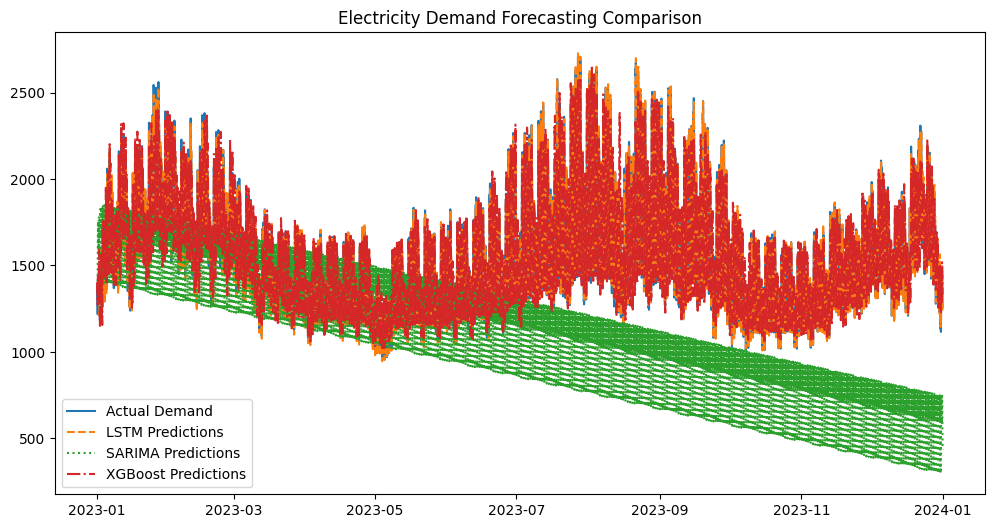

In [27]:
# Reset index for plotting
test = test.reset_index()

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(test['timestamp'], test['actual_performance(10,000 kW)'], label='Actual Demand')
plt.plot(test['timestamp'][seq_length:], lstm_predictions, label='LSTM Predictions', linestyle='dashed')
plt.plot(test['timestamp'], sarima_predictions, label='SARIMA Predictions', linestyle='dotted')
plt.plot(test['timestamp'], xgb_predictions, label='XGBoost Predictions', linestyle='dashdot')
plt.legend()
plt.title("Electricity Demand Forecasting Comparison")
plt.show()


Hypotheses for Accuracy Improvement

1. **Incorporating More Exogenous Variables:** Public holidays and special events could impact electricity demand.
2. **Hyperparameter Tuning:** Optimizing LSTM layers, SARIMA parameters, and XGBoost hyperparameters.
3. **Hybrid Modeling:** Combining LSTM with SARIMA or XGBoost for ensemble learning.
4. **More Training Data:** Using longer historical data to improve model generalization.
"""


Conclusions:

LSTM performs the best, as it closely follows the actual demand curve.

SARIMA performs the worst, as it fails to capture the trend, showing a decreasing pattern.

XGBoost predictions have high variance, meaning it may need better feature selection or hyperparameter tuning.

Overall, the results suggest that deep learning (LSTM) is a better fit for this forecasting problem compared to traditional statistical models (SARIMA) or tree-based methods (XGBoost).